[130.899125 136.1391   132.547525 130.2976   135.491325 131.800875
 131.2357   136.316825 132.54535  131.7664  ]


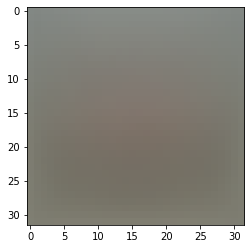

In [2]:
#In this notebook, we'll be optimizing a SVM classifer

#===Data Loading and Splitting - all identical to previous steps, except a smaller dev size
#(Feel free to increase it if you have a powerful computer)
import pickle
import numpy as np
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
import copy
%matplotlib inline

with open("testTrainLab1.pickle", "rb") as f:
    labData = pickle.load(f)
X_train = np.reshape(labData["X_train"], (labData["X_train"].shape[0], -1))
X_test = np.reshape(labData["X_test"], (labData["X_test"].shape[0], -1))
y_train = labData["y_train"]
y_test = labData["y_test"]

trainingSize = 40000
validationSize = 5000
testingSize = 5000
devSize = 100
valMask = range(trainingSize, 50000)
X_val = X_train[valMask]
y_val = y_train[valMask]
trainMask = range(0, trainingSize)
X_train = X_train[trainMask]
y_train = y_train[trainMask]
devMask = range(0, devSize)
X_dev = X_train[devMask]
y_dev = y_train[devMask]


# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
#mean_image = np.mean(X_train, axis=0)
#print(mean_image[:10]) # print a few of the elements
#plt.figure(figsize=(4,4))
#plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
#plt.show()

# second: subtract the mean image from train and test data
#X_train -= mean_image
#X_val -= mean_image
#X_test -= mean_image
#X_dev -= mean_image


In [34]:
#This is our vectorized SVM from the previous step, copied
#and slightly modified to only return totalLoss and the count of correctly classified images
def simpleSVMEffecient(X, y, W, e, l):
    dataLoss = []
    scores = X.dot(W) 

    countTrainSamples = scores.shape[0] 
    countClasses = scores.shape[1] 
    trueClassScores = scores[np.arange(scores.shape[0]), y]
    trueClassMatrix = np.matrix(trueClassScores).T 
    
    #Note - this is a new vectorized implementation of counting the percent of correct
    #cases.
    correct = np.mean(np.equal(trueClassScores, np.amax(scores,axis=1)))

    loss_ij = np.maximum(0, (scores - trueClassMatrix) + e) 
    loss_ij[np.arange(countTrainSamples), y] = 0
    dataLoss = np.sum(np.sum(loss_ij)) / countTrainSamples

    regLoss = np.sum(np.multiply(W,W))
    totalLoss = dataLoss + (l * regLoss)
    return({'totalLoss':totalLoss, 'percentCorrect':(correct*100), 'scores':scores, 'regLoss':regLoss, 'trueClassScores':trueClassScores, 'loss_ij':loss_ij})

#Create a few random weights to test with.  
W = np.random.randn(3072, 10) * .0001

out = simpleSVMEffecient(X_dev, y_dev, W, e=1.0, l=1.0)

print(out['totalLoss'])
print(out['percentCorrect'])

8.747677250406387
14.000000000000002


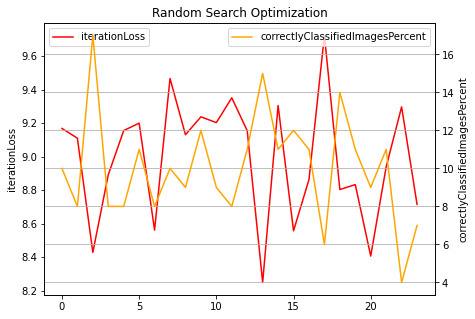

8.714456036785863
7.000000000000001


In [4]:
#Let's implement the most basic of optimization - a random search across weights.
#We'll also visualize the loss function over each iteration.

#Simple routine to visualize our results
#This plot will dynamically update as our model runs.
#Each step in the for loop, we clear the jupyter screen and put a new chart
#with the new results.
def dynamicPlot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    i = 0
    colors = ['red', 'orange', 'blue', 'green']
    loc = ['upper left', 'upper right', 'lower left', 'lower right']
    for label,data in data_dict.items():
        plt.plot(data, label=label, color=colors[i])
        plt.ylabel(label)
        plt.legend(loc = loc[i])
        if(i == 0):
            plt.twinx()
        i = i + 1
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Iteration')
    plt.show()


maxIterations = 25
currentIteration = 1
globalTotalLoss = 999999999

plotData = collections.defaultdict(list)

while currentIteration < maxIterations:
    
    W = np.random.randn(3072, 10) * .0001   
    iterationResult = simpleSVMEffecient(X_dev, y_dev, W, e=1.0, l=1.0)

    if(iterationResult['totalLoss'] < globalTotalLoss):
        globalTotalLoss = iterationResult['totalLoss']
        bestWeights = copy.deepcopy(W)

    #For visualizing our model behavior:
    plotData['iterationLoss'].append(iterationResult['totalLoss'])
    plotData['correctlyClassifiedImagesPercent'].append(iterationResult['percentCorrect'])
    dynamicPlot(plotData, title="Random Search Optimization")

    currentIteration = currentIteration + 1

#For comparison, let's look at the loss function and accuracy of our best set of weights.
out = simpleSVMEffecient(X_dev, y_dev, W, e=1.0, l=1.0)

print(out['totalLoss'])
print(out['percentCorrect'])



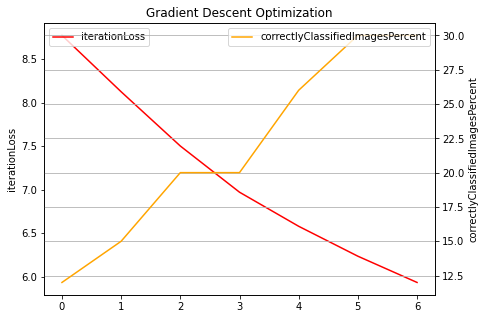

KeyboardInterrupt: 

In [10]:
#A random search isn't the best way to go :).
#So, let's implement a basic gradient descent.
#First, we're going to do a finite differences approach.
#This is more computationally intensive, and not
#exact.

maxIterations = 100
currentIteration = 1
learningRate = .0000001
#Regularization loss importance vs. data loss
l = 1.0
plotData = collections.defaultdict(list)

W = np.random.randn(3072, 10) * .0001

while currentIteration < maxIterations:
    iterationResult = simpleSVMEffecient(X_dev, y_dev, W, e=1.0, l=l)

    #Calculate the gradient at each step
    iterationLoss = iterationResult['totalLoss']
    
    #The gradient we're calculating has one element for each W.
    #These entries can be interpreted as the expected shift in the loss function
    #if W is moved by one unit.
    gradient = np.zeros(W.shape)

    #We define h, 
    #which allows us to estimate the slope at this point on the function.
    h = .0000001
    for i in range(0, len(W)):
        for j in range(0, len(W[i])):
            #We add h to each weight W consecutively, and recalculate our loss. 
            #This is the step that takes a really long time in a finite differences approach!
            newW = W
            newW[i,j] = newW[i,j] + h
            hIterationResults = simpleSVMEffecient(X_dev, y_dev, newW, e=1.0, l=l)
            gradient[i,j] = (hIterationResults['totalLoss'] - iterationResult['totalLoss']) / h

    #Now that we have our gradient, we can add it back to our original weights.
    #Think about what this is doing - the gradient will have large, negative values
    #in cases where changing the weights down reduced the loss function.  So, 
    #we simply add the inverse.

    W = np.subtract(W, learningRate * gradient)

    
    #For visualizing our model behavior:
    plotData['iterationLoss'].append(iterationResult['totalLoss'])
    plotData['correctlyClassifiedImagesPercent'].append(iterationResult['percentCorrect'])
    dynamicPlot(plotData, title="Gradient Descent Optimization")

    currentIteration = currentIteration + 1

#For comparison, let's look at the loss function and accuracy of our best set of weights.
out = simpleSVMEffecient(X_dev, y_dev, W, e=1.0, l=1.0)

print(out['totalLoss'])
print(out['percentCorrect'])



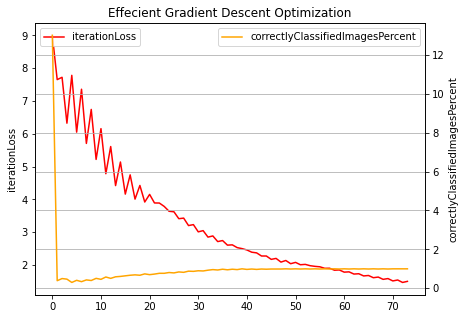

1.4188390058785671
1.0


In [35]:
#Obviously, the finite differences approach is far too
#slow to be used in practice.
#instead, let's calculate the analytic gradient.
maxIterations = 75
currentIteration = 1
learningRate = .000001
#Regularization loss importance vs. data loss
l = 1.0
plotData = collections.defaultdict(list)

W = np.random.randn(3072, 10) * .000000000001


while currentIteration < maxIterations:
    iterationResult = simpleSVMEffecient(X_dev, y_dev, W, e=1.0, l=l)
    
    #Ok!  Back to calculus - to solve for an analytic gradient, 
    #We are programatically seeking to solve for the gradient, just
    #like in the last cell.
    
    #First, we determine the number of non-0 entries in each row of the loss matrix
    #binCheck = iterationResult['loss_ij']
    #binCheck[iterationResult['loss_ij'] > 0] = 1
    #rowSum = np.sum(binCheck, axis=1)
    #binCheck[np.arange(X_dev.shape[0]), y_dev] = -rowSum.T

    
    #scoreDiff = iterationResult['scores'] - np.max(iterationResult['scores'], axis=1).reshape(-1,1)

    #loss_ij = np.maximum(0, (scores - trueClassMatrix) + e) 
    #loss_ij[np.arange(countTrainSamples), y] = 0

    gradient = (X_dev.T).dot(iterationResult['loss_ij'])
    gradient = gradient / X_dev.shape[0]
    gradient = gradient + iterationResult["regLoss"] / X_dev.shape[0]
    
    T = W - (gradient * learningRate)
    W = T
    
    #For visualizing our model behavior:
    plotData['iterationLoss'].append(iterationResult['totalLoss'])
    plotData['correctlyClassifiedImagesPercent'].append(iterationResult['percentCorrect'])
    dynamicPlot(plotData, title="Effecient Gradient Descent Optimization")

    currentIteration = currentIteration + 1

#For comparison, let's look at the loss function and accuracy of our best set of weights.
out = simpleSVMEffecient(X_dev, y_dev, W, e=1.0, l=l)

print(out['totalLoss'])
print(out['percentCorrect'])

